In [1]:
#!pip install chart_studio

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
import os

In this notebook we use a FCNN to solve the forecasting problem. We'll use the same data preparation as for the second model, with the frame of giving the infomation of the previous 24 hours and targetting the next 6. 

# 3.3.1 Loading Data

In [3]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec) 

# 3.3.3 Data preprocesing

Reframe problem: add previous N hours before the variable which will be predicted.

In [4]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in data.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def weather_supervised(dataframe, n_in, n_out):
    df = dataframe.copy()
    df.pop('electricity')
    return series_to_supervised(data = df, n_in = n_in, n_out = n_out, dropnan=True)

def electric_supervised(dataframe, n_in, n_out):
    elec = pd.DataFrame(dataframe['electricity'])
    elec_sup = series_to_supervised(data = elec, n_in = n_in, n_out = n_out, dropnan=True)
    return elec_sup

In [6]:
electricity = electric_supervised(full, 24, 6)
weather = weather_supervised(full, 24, 6)
full = weather.iloc[:,:-6*9].join(electricity)

Separate data from labels

In [7]:
X = full.iloc[:,:-6]
y = full.iloc[:,-6:]

In [8]:
X.shape, y.shape

((26275, 240), (26275, 6))

Building scalers and normalizing

In [9]:
mm = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

Converting arrays to tensors and variables to paralelize training.

In [10]:
#We split the data into 2/3 of the time for training and 1/3 for testing 
#which would lead to 2 years for training and one year fo testing
train_hours = int(2*full.shape[0]/3)

X_train = X_ss[:train_hours, :]
X_test = X_ss[train_hours:, :]
y_train = y_mm[:train_hours, :]
y_test = y_mm[train_hours:, :]

#to tensors and variables
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

For this NN model we don't need to do any reshape of the input tensors.

# 3.3.4 Building the model

The model consists in 4 FC layers with several hidden neurons each, with RELU activation function between them and before the output.

In [11]:
class FCNN_3(nn.Module):
    def __init__(self, num_classes, input_size, device):
        super(FCNN_3, self).__init__()

        self.device = device
        self.num_classes = num_classes #number of outputs
        self.input_size = input_size #input size

        self.a = nn.Linear(input_size, 777)
        self.b = nn.Linear(777, 333) 
        self.c = nn.Linear(333, 333) 
        self.d = nn.Linear(333, 111) 
        self.e = nn.Linear(111, num_classes)

        self.relu = nn.ReLU() 

    def forward(self,x):

        out = self.a(x)
        out = self.relu(out)
        out = self.b(out)
        out = self.relu(out)
        out = self.c(out)
        out = self.relu(out)
        out = self.d(out)
        out = self.relu(out)
        out = self.e(out)
        out = self.relu(out)  
              
        return out 

Create or load model

In [12]:
#checking if there are any saved model checkpoint
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
if os.path.isfile('./data/models/model_3_checkpoint.tar'):
    #load the model
    model = FCNN_3(num_classes = 6, input_size = X_train_tensors.shape[1], device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    # Make sure to call input = input.to(device) on any input tensors that you feed to the model

    checkpoint = torch.load('./data/models/model_3_checkpoint.tar', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(model)
    
else:
    model = FCNN_3(num_classes = 6, input_size = X_train_tensors.shape[1], device=device)
    model.to(device)
    print(model)

FCNN_3(
  (a): Linear(in_features=240, out_features=777, bias=True)
  (b): Linear(in_features=777, out_features=333, bias=True)
  (c): Linear(in_features=333, out_features=333, bias=True)
  (d): Linear(in_features=333, out_features=111, bias=True)
  (e): Linear(in_features=111, out_features=6, bias=True)
  (relu): ReLU()
)


Determining loss criterion, optimizer, num_epochs and learning_rate

In [13]:
learning_rate = 0.001 
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
num_epochs = 1500 

Epoch: 0, loss: 0.12646, val_loss: 0.11534
Epoch: 50, loss: 0.05039, val_loss: 0.05836
Epoch: 100, loss: 0.04982, val_loss: 0.05758
Epoch: 150, loss: 0.04961, val_loss: 0.05742
Epoch: 200, loss: 0.02535, val_loss: 0.02954
Epoch: 250, loss: 0.02515, val_loss: 0.02946
Epoch: 300, loss: 0.02504, val_loss: 0.02945
Epoch: 350, loss: 0.02499, val_loss: 0.02945
Epoch: 400, loss: 0.02490, val_loss: 0.02949
Epoch: 450, loss: 0.02486, val_loss: 0.02956
Epoch: 500, loss: 0.02482, val_loss: 0.02950
Epoch: 550, loss: 0.02479, val_loss: 0.02951
Epoch: 600, loss: 0.00546, val_loss: 0.00480
Epoch: 650, loss: 0.00078, val_loss: 0.00147
Epoch: 700, loss: 0.00073, val_loss: 0.00185
Epoch: 750, loss: 0.00057, val_loss: 0.00167
Epoch: 800, loss: 0.00052, val_loss: 0.00166
Epoch: 850, loss: 0.00048, val_loss: 0.00167
Epoch: 900, loss: 0.00041, val_loss: 0.00142
Epoch: 950, loss: 0.00039, val_loss: 0.00157


Text(0, 0.5, 'MSE loss')

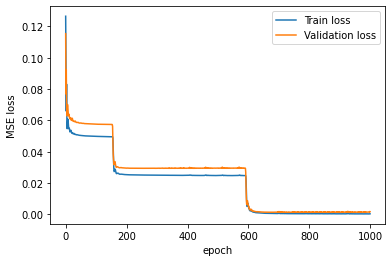

In [29]:
#train 1
model.train()

train_loss = []
val_loss = []
X_test_tensors = X_test_tensors.to(device)
y_test_tensors = y_test_tensors.to(device)
X_train_tensors = X_train_tensors.to(device)
y_train_tensors = y_train_tensors.to(device)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
    # obtain the batch loss 
    loss = criterion(outputs, y_train_tensors)
    train_loss.append(loss.item())
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backpropagation

    #validation
    val_out = model.forward(X_test_tensors)
    loss_val =criterion(val_out, y_test_tensors)
    val_loss.append(loss_val.item())

    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss[epoch], val_loss[epoch])) 

epoch = np.arange(0,num_epochs)

#plotting
plt.plot(epoch, train_loss, label = "Train loss")
plt.plot(epoch, val_loss, label = "Validation loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [30]:
#to save model you'll have to train/keep training the model
torch.save({
            'epoch': len(epoch),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            }, './data/models/model_3_checkpoint.tar')

# 3.3.5 Validating model

Normalizing

In [14]:
df_X_ss = ss.transform(full.iloc[:,:-6]) #old transformers
df_y_mm = mm.transform(full.iloc[:,-6:]) #old transformers
df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

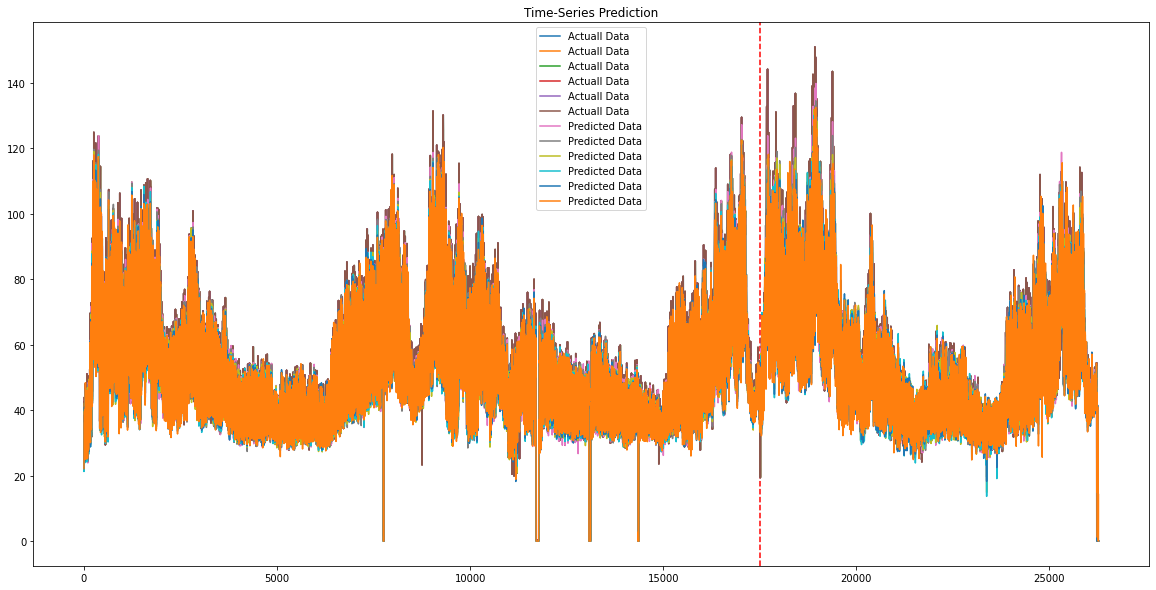

Test RMSE: 4.489


In [15]:
model.eval()

train_predict = model(df_X_ss.to(device))#forward pass
data_predict = train_predict.cpu().data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10)) #plotting
plt.axvline(x=train_hours, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

rmse = np.sqrt(mean_squared_error(dataY_plot, data_predict ))
print('Test RMSE: %.3f' % rmse)

The results are entirely analogous to those obtained with the second model. We'll  repeat the analysis.

We see that the squared root of the MSE on the total data set is of 4.489, which is greater than in the first model, but smaller than the second one.

In [31]:
Predicted = go.Scatter(x=y[train_hours:].index, y=data_predict[train_hours:,0].flatten(), opacity = 1, name = 'Forecasted Value (1)', line=dict(color='darkseagreen'), yaxis='y')
Actual = go.Scatter(x=y[train_hours:].index, y=y['electricity(t)'][train_hours:].values, opacity = 0.5, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')

layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

At first sight, this third model performs better as the past two. It seems that this model estimates in a better way the peaks and the valleys of the daily fluctuations. You can see above the graphs which correspond to the previous used models.

##### 1st. Model overall performance
![1st Model Overall Performance](./data/images/model1_overall_performance.png)

##### 2nd. Model overall performance
![2nd Model Overall Performance](./data/images/model2_overall_performance.png)

However, we've already commented that this performance is strictly under the frame of the problem to solve. 
If we compare the three models in the task of predicting one hour ahead being given previous data, this third ist the best. 
Lets compare them when using their calculated values to make further predictions in time.

## Load forecast using predicted values as input values

In [32]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec)

In [33]:
prev_fut = full.iloc[-1596:-1476,:] #amount of hours equivalent to 5 days
#to change tha amount or domain of hours to work with, change the numbers to cover the domain you
# want to work with.

In [34]:
def daily_consumption_forecast_1(previous_df):
    '''
    Takes previous day weather and electrical load information and predicts next day load profile
    '''
    actual_val = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)
    y_predic = []
    for i in range(previous_df.shape[0]-30):
        #filter out from data frame the 12+1 values which will be used
        #to generate the input tensor. This includes the last predicted value.
        previous = previous_df.iloc[i:i + 30,:]
        #prepare and generate input array
        electricity = electric_supervised(previous, 24, 6)
        weather = weather_supervised(previous, 24, 6)
        in_previous = weather.iloc[:,:-6*9].join(electricity)
        # select inputs and targets
        X_previous = in_previous.iloc[:,:-6]
        y_previous = in_previous.iloc[:,-6:]
        #normalization
        X_val = ss.transform(X_previous)
        y_val = mm.transform(y_previous) 
        #from array to tensors and variables
        X_val_tensors = Variable(torch.Tensor(X_val))
        y_val_tensors = Variable(torch.Tensor(y_val))
        #forward pass
        model.eval()
        y_pred = model.forward(X_val_tensors.to(device))
        #reverse normalization
        y_predict = y_pred.cpu().data.numpy() #numpy conversion
        y_predict = mm.inverse_transform(y_predict)
        #add to dataframe the calculated value for the next hour
        aux = previous['electricity'].values.tolist()
        aux[24] = y_predict.item(0)
        y_predic.append(y_predict.item(0))
        previous_df.iloc[i:i + 30,:]['electricity'] = aux
    prediction = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)

    return prediction, actual_val, y_predic

In [35]:
pd.options.mode.chained_assignment = None
pred,act, y_f = daily_consumption_forecast_1(prev_fut)

In [36]:
Predicted = go.Scatter(x=act.iloc[24:,:].index, y=np.array(y_f), opacity = 1, name = 'Forecasted Value', line=dict(color='lightblue'), yaxis='y')
Actual = go.Scatter(x=act.index, y=act['electricity'].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Actual, Predicted], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

We can see that within this comparison, this one is the worst model of the three. This result suggests that the LSTM layers do improve the capability of this networks to predict further outcomes being given previous values. 
Actually, you can check by yourself that if you passed the whole validation set to the above function to predict the complete 2018 year, it would give a behavior rather close to the actual. However, if you tried it with this 3rd model, you could see that the training set kicks in and somehow, weird patters arise and even high peaks at the end of the year, which do not occur with the previous models.

##### 1st. Model particular performance
![1st Model Overall Performance](./data/images/model1_performance.png)

##### 2nd. Model particular performance
![2nd Model Overall Performance](./data/images/model2_performance.png)

-----